Let's try to solve a first order differential equation using a guess (model) function. This function will be used to adjust the parameters so that the left- and right-hand side of the ODE are as close as possible. 

In [1]:
import os

os.chdir('Optimizers/Gradient-Descent/python/')
import GD as GD 
os.chdir('../../../')

import numpy as np

import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

For example, consider the ODE
$$
\dfrac{dy}{dt}= G(y(t);t) \;,
$$
with $y(0)=y_0$.

we can use a function, $f(t;\{w\})$, that depends on severan parameters (e.g. $f(t;\{w\}) = \sum_{i=0}^{N} w_i \ t^i$) in order to model the solution.

The key point here is that we are not going to fit the model in the entire $t \in [0,T]$. 

Given a list of $t=t_1,t_2 \dots t_N$ for which we wish to find $y(t_i)$. We, then, minimize 
$$
Q(\{w\}) =  \dfrac{1}{2}\Bigg[\left(f(0;\{w\})-y_0\right)^2 + \dfrac{1}{N}\sum_{i=0}^{N} \left(\dfrac{df(t;\{w\})}{dt}- G\Big( \ f(t;\{w\}),t\Big)\right)_{t=t_i}^2 \Bigg]\;.
$$
When this is minimized, we have the values for the $w$ which define a function that has the same initial condition as $y$ and approximately obeys the ODE at any $t$. 

What we need is $\nabla_{w_i} \ Q(\{w\})$, which will be used from the optimizer.

Let's say we want to solve 
$$
\dfrac{dy}{dt}=-sin(t) \;, \; \text{ with} \;\; y(0)=1 \;.
$$

In order to solve it, we will use a model function:
$$
y=w_0 \ sin(w_1 \ t) + w_2 \ cos(w_3 \ t).
$$

Define the model function.

In [2]:
class modelFunc(GD.modelBase):
    def __init__(self,dimensions,w0,h=1e-8):
        GD.modelBase.__init__(self,dimensions,w0)
        
        self.dsdx=[0 for _ in range(dimensions[1])]
        self.h=h
        
    def __call__(self):
        self.signal[0]=np.sin(self.input*self.w[1])*self.w[0]+np.cos(self.input*self.w[3])*self.w[2]
        
    def derivative_x(self):
        _x=self.input
        heff=np.abs(_x)*self.h+self.h
        
        for j in range(self.dimensions[1]):
            _x-=heff
            self.setInput(_x)
            self()
            f0=self.signal[j]
            
            _x+=2*heff
            self.setInput(_x)
            self()
            f1=self.signal[j]
            
            self.dsdx[j]=(f1-f0)/(2*heff)
            
            _x-=heff
            self.setInput(_x)
            
    
    def derivative_w(self,i):
        heff=np.abs(self.w[i])*self.h+self.h
        
        for j in range(self.dimensions[1]):
            self.w[i]-=heff
            self()
            f0=self.signal[j]
            
            self.w[i]+=2*heff
            self()
            f1=self.signal[j]
            
            self.dsdw[j]=(f1-f0)/(2*heff)
            
            self.w[i]-=heff


Define the region in which you want to solve the ODE, and the initial condition.

In [3]:
class Boundary:
    def __init__(self,model,points,y0):
        '''
        model: the model function
        points: the points at which we want the solution
        y0: the value of y at points[0]
        '''
        self.model=model
        self.points=points[:]
        self.y0=y0

        self.NPoints=len(points)
        
        self.boundary_diff=[0 for _ in range(model.dimensions[1])]
        
        self.model.setInput(self.points[0])#start at points[0]
        
    def boundaryDifference(self):
        '''
        get the difference between self.y0 and the output of the model for model.input=points[0]
        '''
        tmp_x=self.model.input
        
        self.model.setInput(self.points[0])
        
        self.model()
        for i,_y in enumerate(self.y0):
            self.boundary_diff[i]=self.model.signal[i] -_y 
            
        self.model.setInput(tmp_x)
        

Define the ODE, which basically also defines the loss, which will be used to train the model.

In [4]:
class DifferentialEquation:
    def __init__(self,Model,Boundary):
        
        self.model=Model
        self.boundary=Boundary
        
        self.DE=[0 for _ in range(self.model.dimensions[1])]#this should be LHS-RHS, which we want to be 0 (see definition of __call__)
        self.grad=[0 for i in  range(self.model.dim)]
        
        
    def __call__(self):
        self.model()
        self.model.derivative_x()
        for i,dMdx in enumerate(self.model.dsdx):
            self.DE[i] = dMdx+np.sin(self.model.input)
        
        
    
    def averageLoss(self):
        '''get the average total loss'''
        
        avrgLoss=0
        
        #average loss for the initial condition
        self.boundary.boundaryDifference()
        for dim in range(self.model.dimensions[1]):
            avrgLoss+=(self.boundary.boundary_diff[dim]**2)
        
        #average loss for the derivatives 
        for i,p in enumerate(boundary.points):
            model.setInput(p)
            self()
            for dim in range(self.model.dimensions[1]):
                avrgLoss+=(self.DE[dim]**2)/(1.*boundary.NPoints)
        
        return avrgLoss/(2.*self.model.dimensions[1])
        

    def averageGrad(self,h=1e-8):
        '''Get the gradient of the averge loss at current point and a random boundary point'''
        '''we should find a way to do it analytically (at least the dQds part)'''
        
        for dim in range(self.model.dim):
            heff=h*np.abs(self.model.w[dim])+h
            
            self.model.w[dim]-=heff
            Q0=self.averageLoss()

            self.model.w[dim]+=2*heff
            Q1=self.averageLoss()
            
            self.grad[dim]=(Q1-Q0)/(2.*heff)

            self.model.w[dim]-=heff
        


In [5]:
model=modelFunc([1,1],np.random.rand(4)*2-1)
boundary=Boundary(model,np.linspace(0,3.14159,50),[1])
ODE=DifferentialEquation(model,boundary)

In [6]:
# gd=GD.VanillaGD(ODE,alpha=1e-2)
# gd=GD.RMSpropGD(ODE,gamma=1-1e-2,epsilon=1e-5,alpha=1e-1)
# gd=GD.AdaDeltaGD(ODE,gamma=0.99,epsilon=1e-5,alpha=1)
# gd=GD.AdamGD(ODE,beta_m=0.9,beta_v=0.999,epsilon=1e-8,alpha=1e-1)
# gd=GD.AdaMaxGD(ODE,beta_m=0.9,beta_v=0.999,epsilon=1e-8,alpha=1e-1)
gd=GD.NAdamGD(ODE,beta_m=0.9,beta_v=0.999,epsilon=1e-8,alpha=1e-1)

In [7]:
gd.run(abs_tol=1e-3, rel_tol=1e-3, step_break=50,max_step=5000)

array([ 0.00116078, -0.1323047 ,  0.99993115,  1.00000808])

<IPython.core.display.Javascript object>


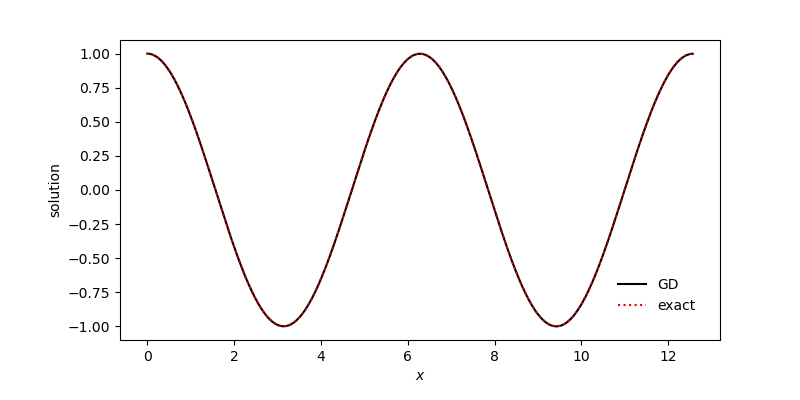

In [8]:
fig=plt.figure(figsize=(8,4))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#

sub = fig.add_subplot(111)

x=np.linspace(0,np.pi*4,500)
y=[]
for _x in x:
    model.setInput(_x)
    model()
    y.append(model.signal[0])
y=np.array(y)
sub.plot(x,y,c='xkcd:black',linestyle="-",label='GD')
sub.plot(x,np.cos(x),c='xkcd:red',linestyle=":",label='exact')


sub.legend(framealpha=0,ncol=1,loc='lower right',bbox_to_anchor=(0.98,0.05))

sub.set_ylabel('solution')
sub.set_xlabel('$x$')

sub.set_xscale('linear')
sub.set_yscale('linear')

plt.show()